https://github.com/bnsreenu/python_for_microscopists/blob/master/214_multiclass_Unet_sandstone_segm_models_ensemble.py


In [26]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
#https://segmentation-models.readthedocs.io/en/latest/api.html#unet
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple

In [27]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [28]:
# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path) #leggo l'immagine con i suoi 3 canali rgb
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [29]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [30]:
#Carico il dataset aumentato
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
#Trasformo in un array utilizzabile per i calcoli
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
#Espando la dimensione  della maschera (w,h,1)
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

In [31]:
print(image_dataset.shape)
print(mask_dataset_encoded.shape)
print("Image shape: ", image_dataset[0].shape)
print("Mask shape: ", mask_dataset_encoded[0].shape)
print("Max pixel value in image is: ", image_dataset.max()) #255 perchè non è normalizzata
print("Labels in the mask are : ", np.unique(mask_dataset_encoded))

(1688, 128, 128, 3)
(1688, 128, 128, 1)
Image shape:  (128, 128, 3)
Mask shape:  (128, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3 4]


In [32]:

#Normalize images (pixel diventano tra 0 e 1)
#image_dataset = image_dataset /255. #operazione inutile in questo caso dato che poi effettuo preprocessing dell'input

In [33]:
#Split nel dataset di training, validation e test
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")    

Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [34]:
#Le maschere devono avere il formato dell'ultimo layer del modello (w x h x num_classi)
#One hot encoding dei valori delle maschere
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat =val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))
print("shape precedente: ", y_train.shape)
print("shape attuale: ", y_train_cat.shape)


shape precedente:  (1080, 128, 128, 1)
shape attuale:  (1080, 128, 128, 5)


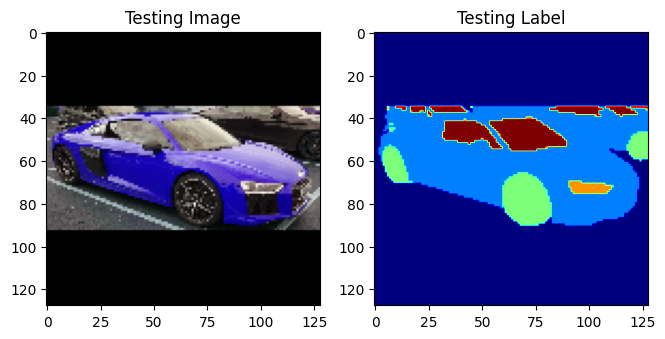

In [35]:
#Sanity check delle immagini
n = random.randint(0, len(X_test)-1)
test_img = X_train[n]
ground_truth=y_train[n]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')

The term backbone refers to the feature-extracting network that processes input data into a certain feature representation. 
https://www.researchgate.net/publication/338723610/figure/fig2/AS:849954893467651@1579656446543/U-net-architecture-with-ResNet34-blocks-in-the-down-sampling-path_Q640.jpg
Backbone consigliato: resnet34 o vgg16: https://iopscience.iop.org/article/10.1088/1742-6596/1544/1/012196 

In [36]:
#Preparo il modello
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input in modo che sia nella forma corretta per essere utilizzato dalla rete (effettua normalizzazione)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [37]:
#Imposto l'input shape per la rete sulla base delle immagini
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)
print(X_train.shape)
print(X_test.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(128, 128, 3)
(1080, 128, 128, 3)
(338, 128, 128, 3)
(1080, 128, 128, 5)
(338, 128, 128, 5)


Spiegazione della IOU SCORE: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
Perchè usare IOU come funzione di loss: https://fse.studenttheses.ub.rug.nl/18139/1/AI_BA_2018_FlorisvanBeers.pdf

In [38]:
# define model
activation = 'softmax' #multiclasse
#Inserisco anche uno strato di batch normalization tra Conv2D e Activation
model = sm.Unet(BACKBONE,input_shape=input_shape, classes=n_classes, activation=activation, encoder_weights='imagenet',decoder_use_batchnorm=True)
#Utilizzo come metrica principale IOU score ma mantengo anche FScore e accuracy per completezza
metrics = [sm.metrics.iou_score,sm.metrics.FScore(threshold=0.5), 'accuracy']
loss = sm.losses.bce_jaccard_loss
#Di default adam usa un learning rate di 0.001
model.compile('Adam', loss=loss, metrics=metrics,)

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                            

In [39]:
from keras.callbacks import CSVLogger
#Fase di TRAINING del modello, early stopping con pazienza a 5
csv_logger = CSVLogger('UNet_segm.log', separator=',', append=False)
callbacks =[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
percorso = os.path.join("..",'UNet_segm.hdf5')
#Salvo solo i pesi migliori del modello
m_save = ModelCheckpoint(percorso, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=80, 
                    validation_data=(X_val, y_val_cat), 
                    callbacks=[callbacks,csv_logger, m_save],
                    shuffle=True)

Epoch 1/80
68/68 [==============================] - 196s 3s/step - loss: 0.7780 - iou_score: 0.4396 - f1-score: 0.5911 - accuracy: 0.8813 - val_loss: 0.8705 - val_iou_score: 0.3734 - val_f1-score: 0.5908 - val_accuracy: 0.8653
Epoch 2/80
68/68 [==============================] - 189s 3s/step - loss: 0.4090 - iou_score: 0.6488 - f1-score: 0.7203 - accuracy: 0.9609 - val_loss: 0.4887 - val_iou_score: 0.5920 - val_f1-score: 0.7047 - val_accuracy: 0.9525
Epoch 3/80
68/68 [==============================] - 189s 3s/step - loss: 0.3536 - iou_score: 0.6894 - f1-score: 0.7504 - accuracy: 0.9681 - val_loss: 0.4129 - val_iou_score: 0.6485 - val_f1-score: 0.7799 - val_accuracy: 0.9620
Epoch 4/80
68/68 [==============================] - 187s 3s/step - loss: 0.2899 - iou_score: 0.7470 - f1-score: 0.8375 - accuracy: 0.9715 - val_loss: 0.3281 - val_iou_score: 0.7163 - val_f1-score: 0.8226 - val_accuracy: 0.9670
Epoch 5/80
68/68 [==============================] - 181s 3s/step - loss: 0.2608 - iou_score:

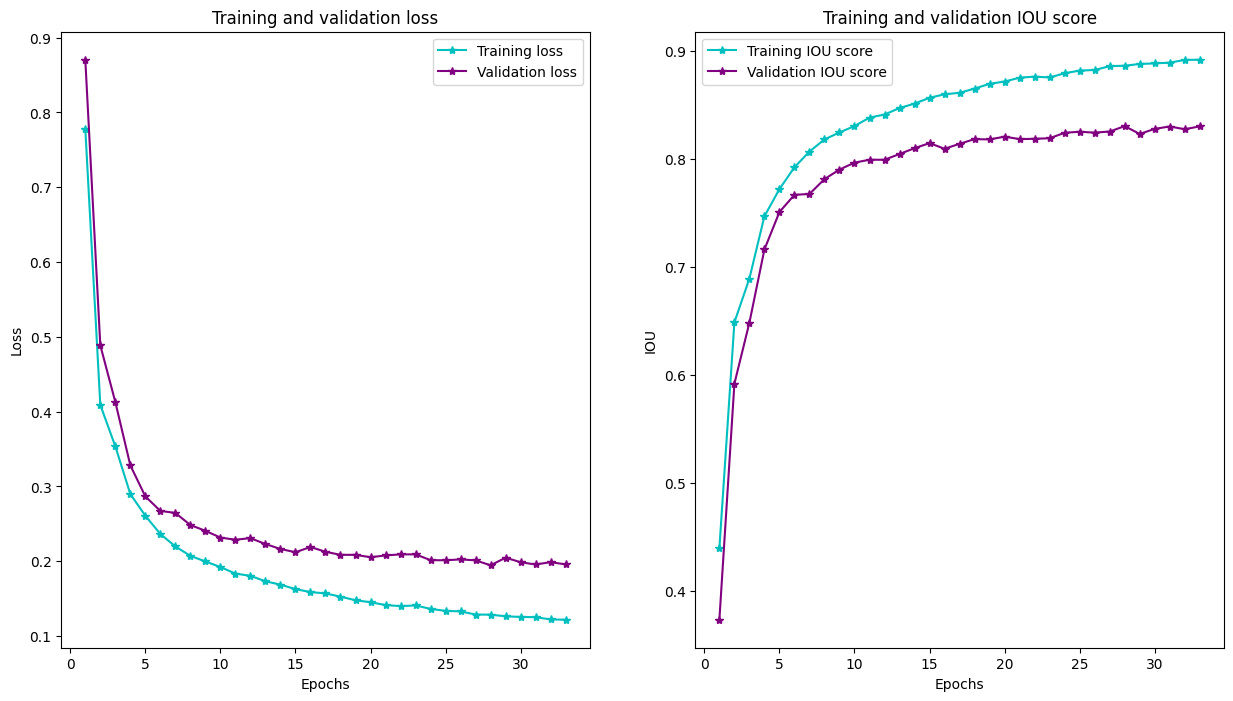

In [47]:
fig = plt.figure(figsize=(15, 8))
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss,'purple', marker="*", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')


acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'c', marker="*", label='Training IOU score')
plt.plot(epochs, val_acc, 'purple', marker="*", label='Validation IOU score')
plt.title('Training and validation IOU score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend(loc='best')

In [48]:
#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet_segm.hdf5")
model = load_model(path, compile=False) #tf.keras.models.load_model
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, 134, 134, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                            

In [52]:
y_pred=model.predict(X_test)
y_pred.shape #5 canali (correttamente)

11/11 [==============================] - 9s 799ms/step


(338, 128, 128, 5)

In [53]:
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3) 
y_pred_argmax.shape

(338, 128, 128)

1/1 [==============================] - 0s 63ms/step


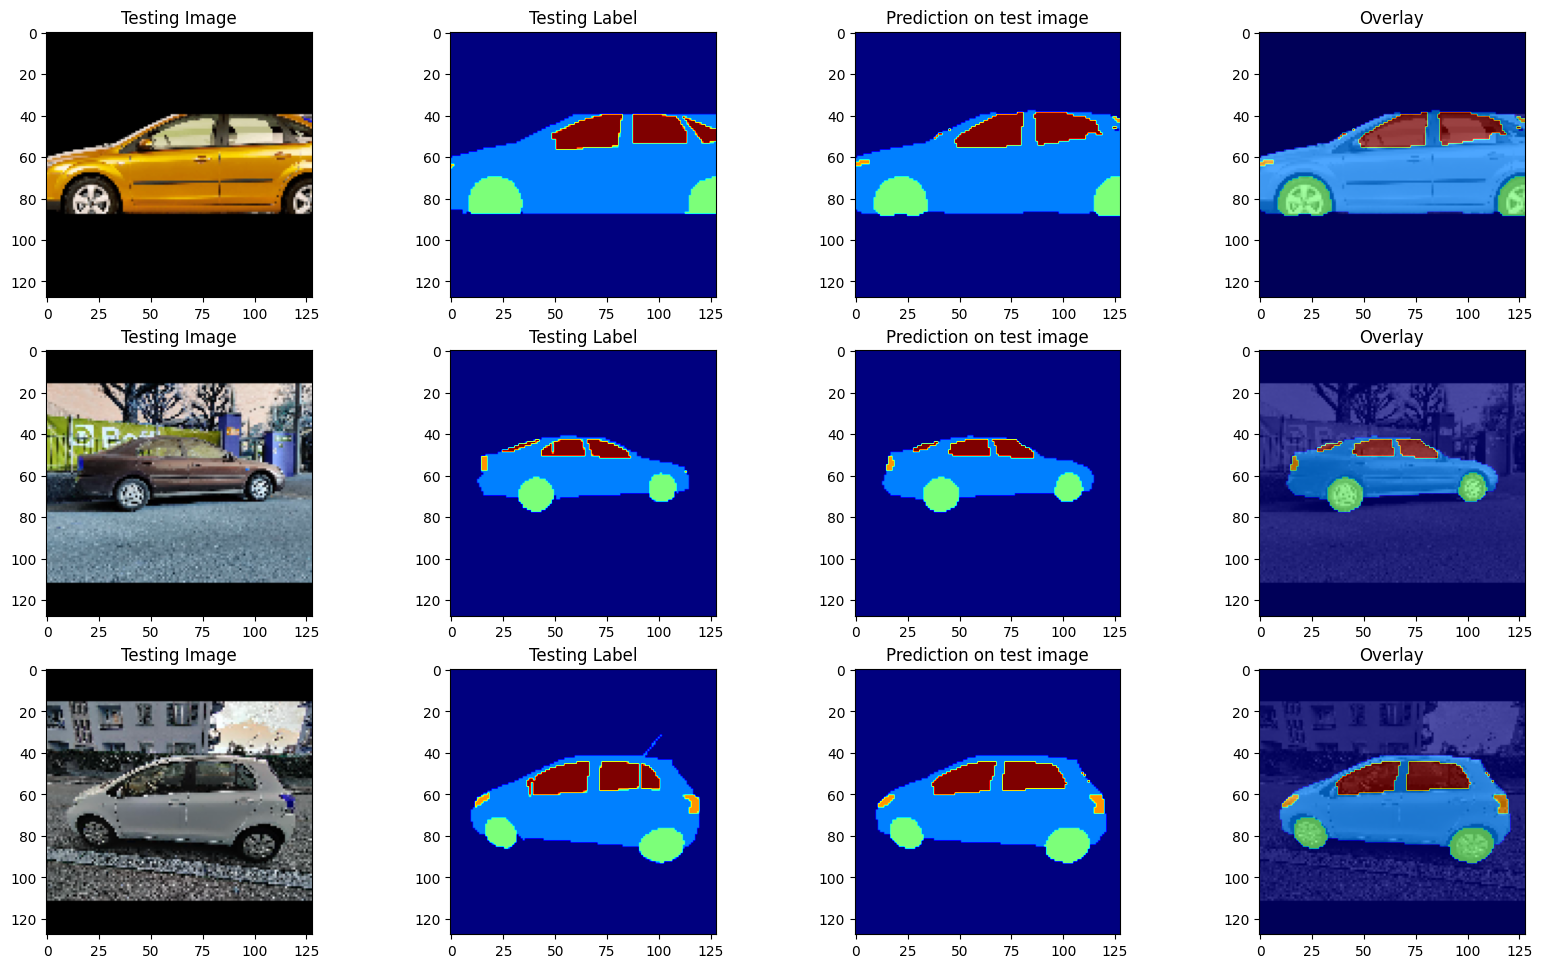

In [56]:
import random
#Mostro alcuni risultati del modello
fig = plt.figure(figsize=(20, 20))

for i in range(3):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    test_img_input = np.expand_dims(test_img,0)
    ground_truth=y_test[test_img_number]
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
    #plt.show()